In [23]:
import numpy as np 


import sys
import os

import jax
import jax.numpy as jnp 

import matplotlib.pyplot as plt

from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.tests.rpsd_test_data import generate_rpsd_data
from kltpicker_3d.tomogram import factorize_RPSD
from kltpicker_3d.utils import * 


plt.style.use('ggplot')

In [24]:
K = 200
N = 32
uniform_points, bins = generate_uniform_radial_sampling_points(N)
H, samples =  generate_rpsd_data(K,N,2)

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/rpsd_test_data.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


In [25]:
factorization = factorize_RPSD(samples)

/tmp/ipykernel_291307/3199449343.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


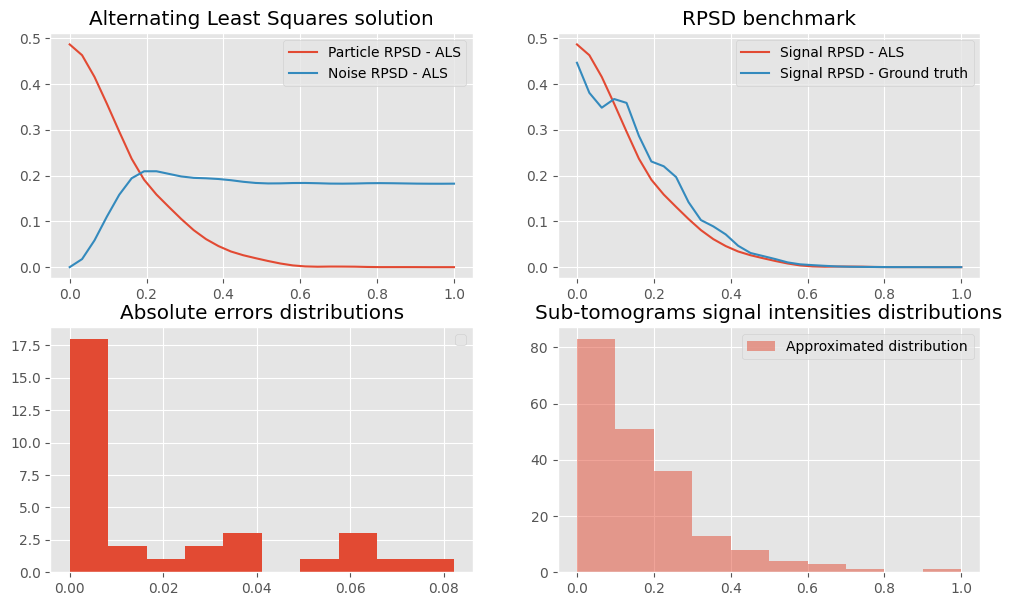

In [26]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
ax[0,1].legend()
ax[0,1].set_title("RPSD benchmark")
ax[0,1].legend()

ax[1,0].set_title("Absolute errors distributions")
ax[1,0].hist(np.abs(true_rpsd - particle_psd));
ax[1,0].legend()

ax[1,1].set_title("Sub-tomograms signal intensities distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

In [ ]:
import scipy
from scipy.special import legendre
import scipy.integrate as integrate

def cpu_integral_equation_solver(Gx,N,K=150):
  def Hn(x):
    p = legendre(N)
    if N % 2 == 0:
        return 4 * np.pi * integrate.quad(lambda u: np.cos(x*u) * p(u), 0,1)[0]
    return 4 * np.pi * integrate.quad(lambda u: np.sin(x*u),0,1)[0]
  
  X,w = scipy.special.roots_legendre(K)
  X_scaled = 0.5*X + 0.5

  vv = np.array([[Hn(X_scaled[i]*X_scaled[j]) for j in range(K)] for i in range(K)])
  def psi(i,j):
    return 0.5 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (X_scaled[j]*X_scaled)**2)

  U = np.array([[w[j]*psi(i,j) for j in range(K)] for i in range(K)])

  eigenvalues, eigenvectors = scipy.linalg.eig(U)
  return eigenvalues,eigenvectors

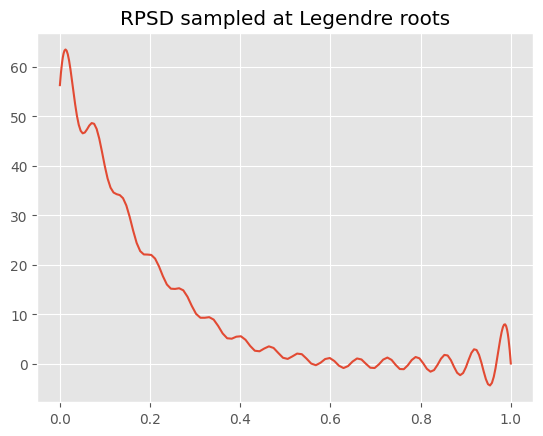

In [136]:
particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = 0.5*X + 0.5
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
true_G = (1/np.sqrt(2*np.pi * 1 ** 2)) * np.exp(- X_scaled ** 2 / (2*1 ** 2)) * (1 + 0.1 * np.cos(10*X_scaled))
plt.title("RPSD sampled at Legendre roots")
plt.plot(X_scaled, Gx);

In [80]:
order = 10
eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
eigenvalues = np.absolute(eigenvalues)
indices = np.argsort(eigenvalues)[::-1]

/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


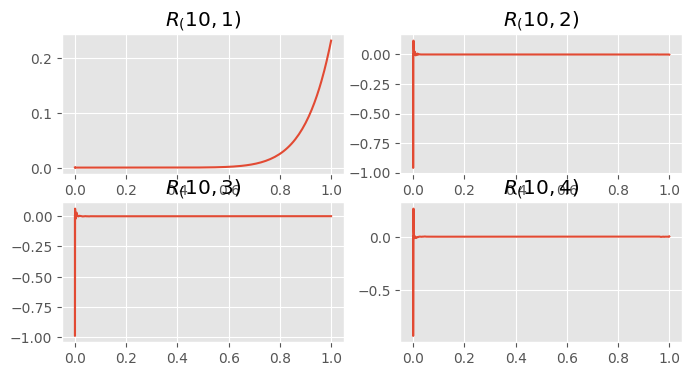

In [94]:
fig, ax = plt.subplots(2,2, figsize=(8,4))


ax[0,0].plot(X_scaled,eigenfunctions[:,indices[0]])
ax[0,0].set_title(f"$R_{10,1}$")


ax[0,1].plot(X_scaled,eigenfunctions[:,indices[20]])
ax[0,1].set_title(f"$R_{order,2}$")

ax[1,0].plot(X_scaled,eigenfunctions[:,indices[2]])
ax[1,0].set_title(f"$R_{order,3}$")

ax[1,1].plot(X_scaled,eigenfunctions[:,indices[6]])
ax[1,1].set_title(f"$R_{order,4}$");

After plotting a few it seems as if for a given order N, the eigenfunctions $R_{N,m}$ are redundant for $m>1$.

Note the solutions are of the form:

$$ \psi_{N,m,n}(r,\theta,\phi) = R_{N,m}(r) S_{m,n}(\theta,\phi)$$

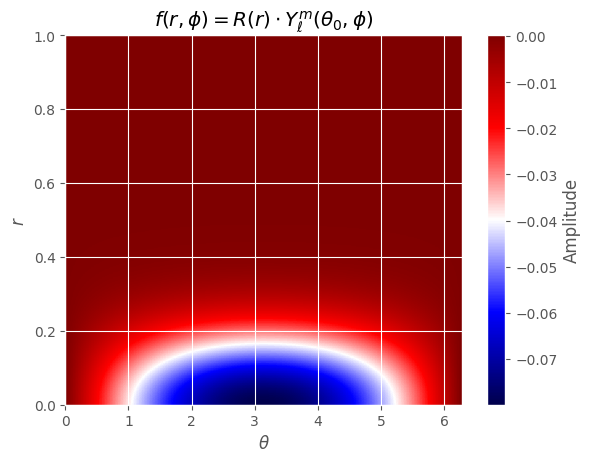

In [ ]:
from matplotlib import cm, colors 
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D 
from scipy.special import sph_harm 


N = 150 
R = eigenfunctions[:,indices[0]].real 

l,m = 1,1
phi = np.linspace(0, 1*np.pi, N)
theta0 = 0
Y = np.real(sph_harm(m,l,theta0, phi))

psi = np.outer(R, Y)    

Y_min, Y_max = Y.min(), Y.max()
Y_norm = 2 * (Y - Y_min)/(Y_max - Y_min) - 1
Y_colors = 0.5 * (Y_norm + 1)

psi = np.outer(R,Y)
plt.imshow(psi, aspect='auto', 
           extent=[0,2*np.pi,0,1.0],
           cmap='seismic')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$r$')
plt.title(r'$f(r, \phi) = R(r) \cdot Y_\ell^m(\theta_0, \phi)$')
plt.colorbar(label='Amplitude')
plt.show()



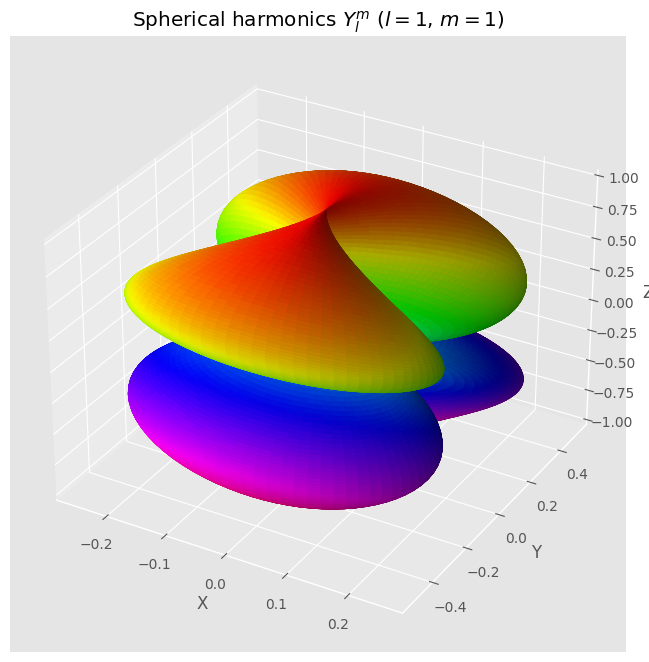

In [168]:
theta = np.linspace(0, np.pi, N)
phi = np.linspace(0, 2*np.pi, N)
theta, phi = np.meshgrid(theta, phi)

l = 1
m = 1
Y = sph_harm(m, l, theta, phi)
Y_real = np.real(Y)

Ymax, Ymin = Y_real.max(), Y_real.min()
if (Ymax != Ymin):
    Y_real = 2 * (Y_real - Ymin)/(Ymax - Ymin) - 1
    radii = np.abs(Y_real)
    Ycolors = 0.5 * (Y_real + 1)
else:
    radii = np.ones(Y_real.shape)
    Ycolors = np.ones(Y_real.shape)
 
x = radii * np.sin(theta) * np.cos(phi)
y = radii * np.sin(theta) * np.sin(phi)
z = radii * np.cos(theta)
 

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, 
                facecolors=cm.hsv(Ycolors))
# ax.view_init(elev=20, azim=20, roll=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(rf"Spherical harmonics $Y_l^m$ ($l={l}$, $m={m}$)")
plt.show()

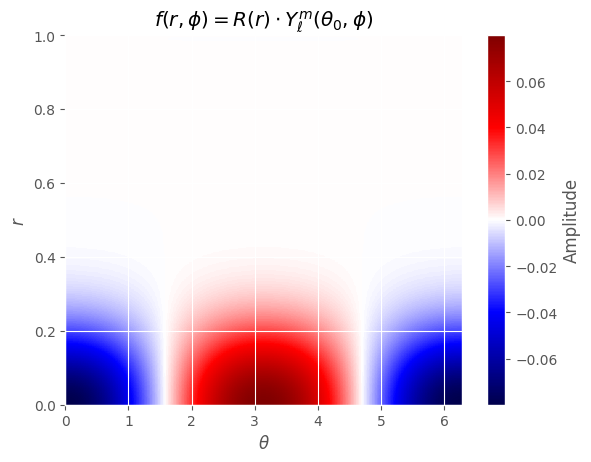

In [183]:
N = 150 
R = eigenfunctions[:,indices[0]].real 

l,m = 1,1
phi = np.pi/2
theta0 = np.linspace(0, 2*np.pi, N)
Y = np.real(sph_harm(m,l,theta0, phi))

psi = np.outer(R, Y)

Y_min, Y_max = Y.min(), Y.max()
Y_norm = 2 * (Y - Y_min)/(Y_max - Y_min) - 1
Y_colors = 0.5 * (Y_norm + 1)

psi = np.outer(R,Y)
plt.imshow(psi, aspect='auto', 
           extent=[0,2*np.pi,0,1.0],
           cmap='seismic')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$r$')
plt.title(r'$f(r, \phi) = R(r) \cdot Y_\ell^m(\theta_0, \phi)$')
plt.colorbar(label='Amplitude')
plt.show()



In [185]:
order = 4
eigenvalues, eigenfunctions = cpu_integral_equation_solver(Gx,order)
eigenvalues = np.absolute(eigenvalues)
indices = np.argsort(eigenvalues)[::-1]

/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


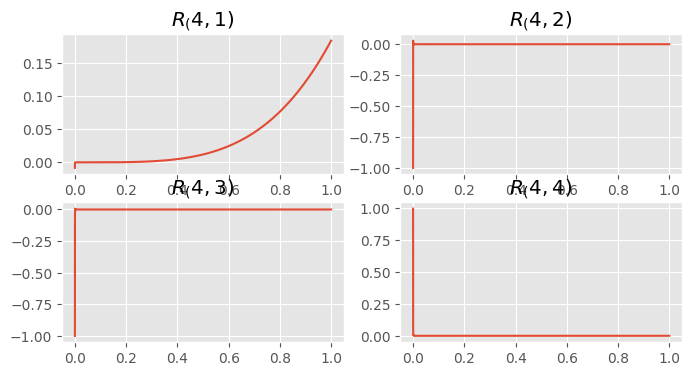

In [186]:
fig, ax = plt.subplots(2,2, figsize=(8,4))


ax[0,0].plot(X_scaled,eigenfunctions[:,indices[0]])
ax[0,0].set_title(f"$R_{order,1}$")


ax[0,1].plot(X_scaled,eigenfunctions[:,indices[20]])
ax[0,1].set_title(f"$R_{order,2}$")

ax[1,0].plot(X_scaled,eigenfunctions[:,indices[2]])
ax[1,0].set_title(f"$R_{order,3}$")

ax[1,1].plot(X_scaled,eigenfunctions[:,indices[6]])
ax[1,1].set_title(f"$R_{order,4}$");

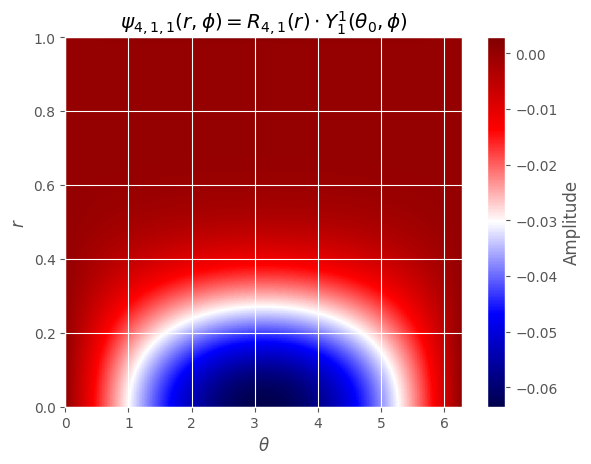

In [196]:
R = eigenfunctions[:,indices[0]].real 

l,m = 1,1
phi = np.linspace(0, 1*np.pi, N)
theta0 = 0
Y = np.real(sph_harm(m,l,theta0, phi))

psi = np.outer(R, Y)    

Y_min, Y_max = Y.min(), Y.max()
Y_norm = 2 * (Y - Y_min)/(Y_max - Y_min) - 1
Y_colors = 0.5 * (Y_norm + 1)

psi = np.outer(R,Y)
plt.imshow(psi, aspect='auto', 
           extent=[0,2*np.pi,0,1.0],
           cmap='seismic')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$r$')
plt.title(r'$\psi_{4,1,1} (r, \phi) = R_{4,1}(r) \cdot Y_1^1(\theta_0, \phi)$')
plt.colorbar(label='Amplitude')
plt.show()
